In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import nibabel as nib
import numpy as np
import pandas as pd
from scipy import stats
from nilearn import datasets
from nilearn.masking import apply_mask
from nilearn.image import resample_to_img

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_fd(motion):
    # assuming rotations in degrees
    motion = np.vstack((np.array([[0, 0, 0, 0, 0, 0]]),
                        np.diff(motion, axis=0)))
    fd = np.sum(np.abs(motion), axis=1)
    return fd

In [3]:
mask_img = nib.load('/Users/tsalo/Documents/tsalo/NiMARE/nimare/resources/templates/MNI152_2mm_mask.nii.gz')
subjects = datasets.fetch_adhd(n_subjects=3)
subj_idx = 2
df = pd.read_csv(subjects.confounds[subj_idx], sep='\t')
red_df = df[['motion-pitch', 'motion-roll', 'motion-yaw',
             'motion-x', 'motion-y', 'motion-z']]
red_df = red_df.rename(columns={'motion-x': 'X',
                                'motion-y': 'Y',
                                'motion-z': 'Z',
                                'motion-pitch': 'P',
                                'motion-roll': 'R',
                                'motion-yaw': 'Ya'})
red_df[['R', 'P', 'Ya']] = red_df[['R', 'P', 'Ya']] * 50 * (np.pi/180.)
motion = red_df.values
red_df['FD'] = get_fd(motion)

func_img = nib.load(subjects.func[subj_idx])
func_img2 = resample_to_img(func_img, mask_img)

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/nilearn/datasets/func.py:501: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


In [4]:
def carpetplot(img, masks, lines_df):
    assert lines_df.shape[0] == img.shape[-1]
    x = 15
    y = 8
    data = apply_mask(img, masks[0])
    data = stats.zscore(data, axis=0).T
    
    tr = img.header.get_zooms()[-1]
    secs = tr * data.shape[1]
    mins = (secs - 1) / 60
    mins = '{0:.01f}'.format(mins)

    fig = plt.figure(figsize=(x, y))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3]) 
    ax0 = plt.subplot(gs[0])
    for col in lines_df.columns[:-1]:
        line_data = lines_df[col].values
        ax0.plot(line_data, label=col)
    ax0.set_xticks([])
    ax0.set_yticks([-1, 1])
    ax0.set_ylim(-1, 1)
    ax0.set_ylabel('Position\n(mm)', fontsize=14)
    ax0.set_title('Head position & motion', fontsize=18)
    ax0.tick_params(axis=u'both', which=u'both',length=0)
    
    ax0_ = ax0.twinx()
    #ax0_ = gs[0].add_subplot(111, sharex=ax0, frameon=False)
    ax0_.plot(lines_df['FD'], label='FD')
    ax0_.set_yticks([0, 2])
    ax0_.set_ylim(0, 2)
    ax0_.yaxis.tick_right()
    ax0_.yaxis.set_label_position("right")
    ax0_.set_ylabel('FD\n(mm)', rotation=270, fontsize=14)
    ax0_.set_xlim(0, data.shape[1]-1)
    ax0_.tick_params(axis=u'both', which=u'both',length=0)
    
    legend = ax0.legend(frameon=True, ncol=3)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    
    ax1 = plt.subplot(gs[1])
    asp = (y / x) * (data.shape[1] / data.shape[0])
    asp = 0.00025
    ax1.imshow(data, cmap='Greys', aspect=asp)
    ax1.set_xlabel('Time (min)', fontsize=18)
    ax1.set_xticks([0, data.shape[1]-1])
    ax1.set_xticklabels([0, mins])
    ax1.set_yticks([])
    ax1.tick_params(axis=u'both', which=u'both',length=0)
    ax1.set_title('Optimally combined (not denoised)', fontsize=18)
    fig.tight_layout()
    return fig, [ax0, ax1]

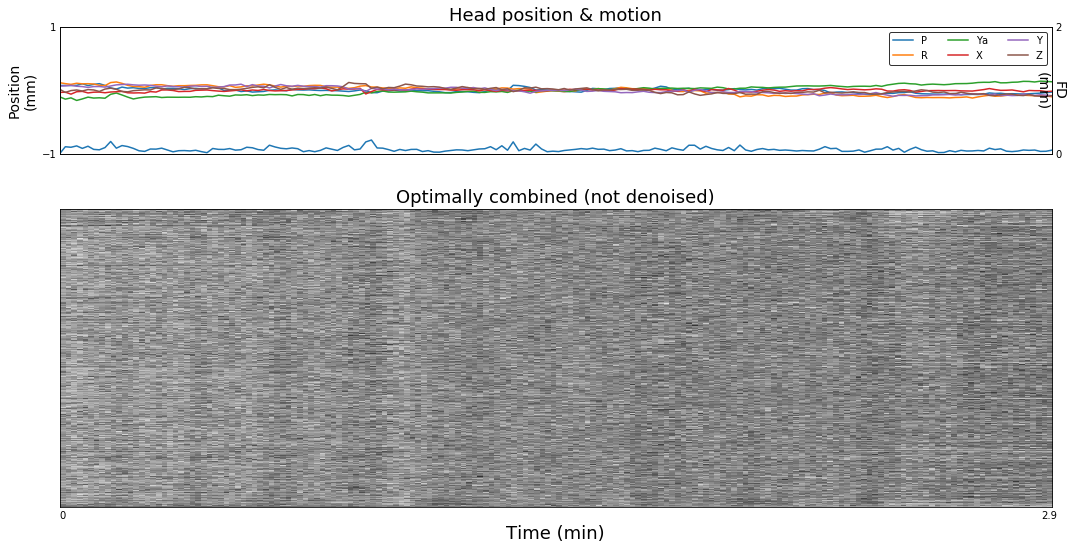

In [5]:
fig, axes = carpetplot(func_img2, [mask_img], red_df)